# Import Necessary Libraries

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling  
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [2]:
import numpy as np
import random
import tensorflow as tf

# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)

seed_everything()

# Create helper functions

In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

# Load and Transform Data

In [4]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [5]:
# Walk through each directory
dataset = r"C:\Users\CHARM\Desktop\Machine Learning Projects\Animal_Classification\dataset"
walk_through_dir(dataset)

There are 15 directories and 0 images in 'C:\Users\CHARM\Desktop\Machine Learning Projects\Animal_Classification\dataset'.
There are 0 directories and 125 images in 'C:\Users\CHARM\Desktop\Machine Learning Projects\Animal_Classification\dataset\Bear'.
There are 0 directories and 137 images in 'C:\Users\CHARM\Desktop\Machine Learning Projects\Animal_Classification\dataset\Bird'.
There are 0 directories and 123 images in 'C:\Users\CHARM\Desktop\Machine Learning Projects\Animal_Classification\dataset\Cat'.
There are 0 directories and 131 images in 'C:\Users\CHARM\Desktop\Machine Learning Projects\Animal_Classification\dataset\Cow'.
There are 0 directories and 127 images in 'C:\Users\CHARM\Desktop\Machine Learning Projects\Animal_Classification\dataset\Deer'.
There are 0 directories and 122 images in 'C:\Users\CHARM\Desktop\Machine Learning Projects\Animal_Classification\dataset\Dog'.
There are 0 directories and 129 images in 'C:\Users\CHARM\Desktop\Machine Learning Projects\Animal_Classif

# Placing data into a Dataframe

In [6]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [7]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

C:\Users\CHARM\AppData\Local\Temp\ipykernel_2352\1784247746.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, ax=axes, palette=custom_palette, hue=None)


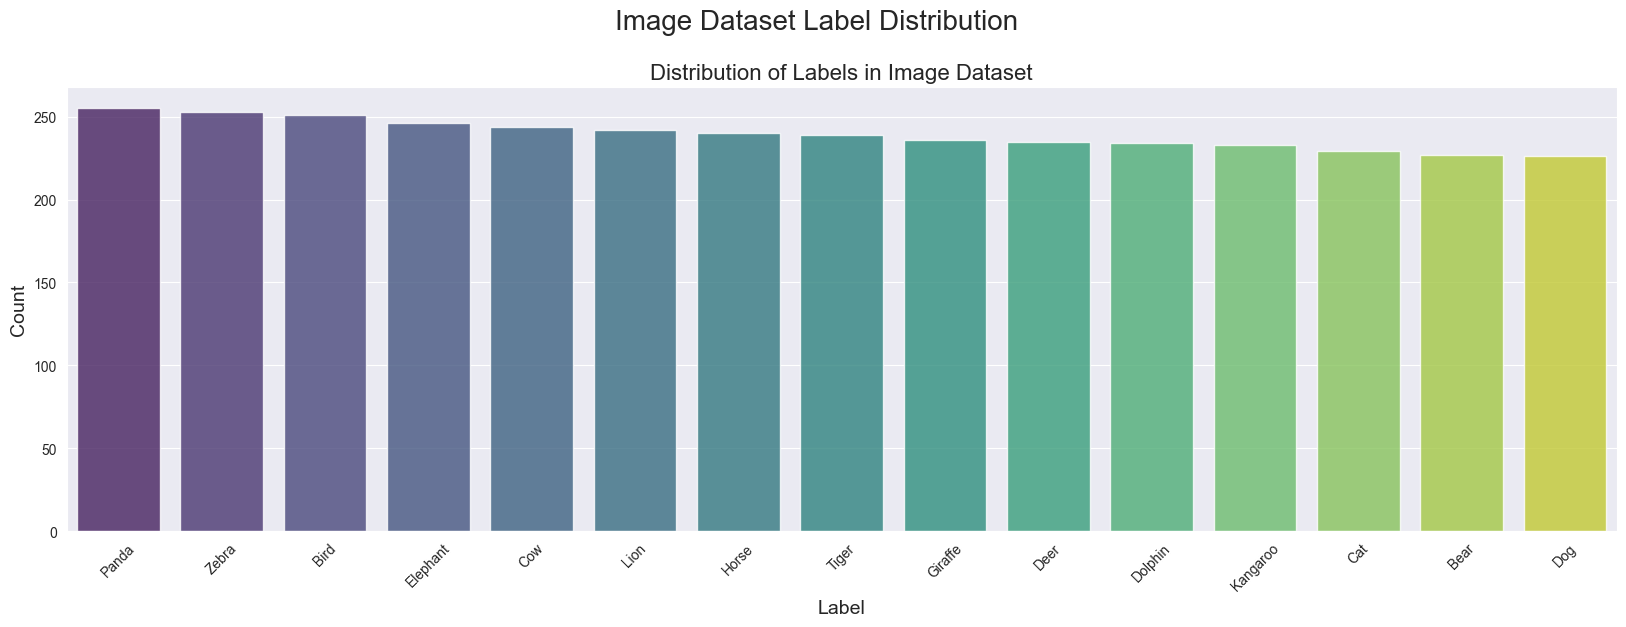

In [8]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Define a custom color palette
custom_palette = sns.color_palette("viridis", len(label_counts))  # Using 'viridis' palette, but you can change it

# Plot the bar chart with the custom palette and hue set to None
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, ax=axes, palette=custom_palette, hue=None)

# Set the title and labels
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)

# Set ticks and tick labels
axes.set_xticks(np.arange(len(label_counts.index)))  # Set x-ticks
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()


# Visualizing images from the dataset

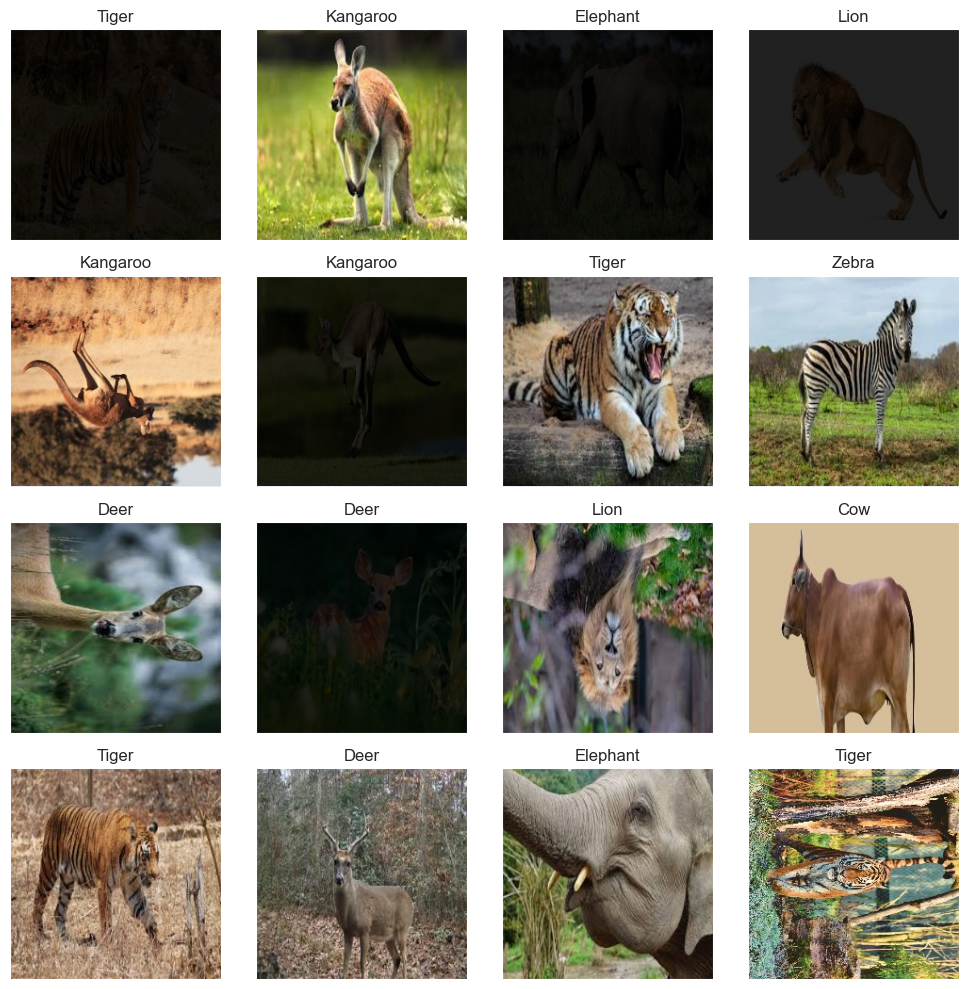

In [9]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Computing Error Rate Analysis

In [10]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

Found 1944 images in the directory: C:\Users\CHARM\Desktop\Machine Learning Projects\Animal_Classification\dataset


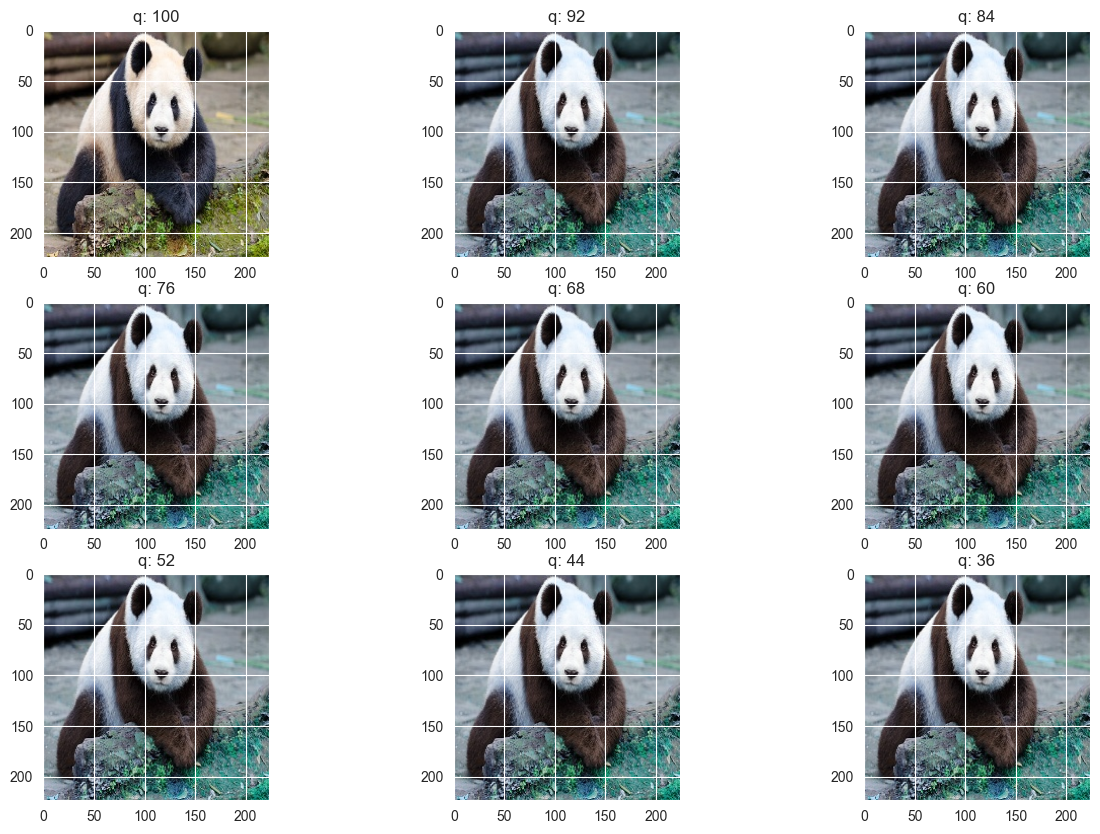

In [11]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Define the random sample function
def random_sample(path):
    # Recursively find all image files in the directory and its subdirectories
    items = list(Path(path).rglob('*.jpg')) + \
            list(Path(path).rglob('*.jpeg')) + \
            list(Path(path).rglob('*.png'))
    
    print(f"Found {len(items)} images in the directory: {path}")  # Print the number of found images
    
    if not items:
        raise IndexError('Cannot choose from an empty sequence')
    return random.choice(items)

# Define the compute_ela_cv function
def compute_ela_cv(path, quality):
    # Load the image
    image = cv2.imread(path)
    
    # Perform any transformation, such as compression or other operations
    # For now, just return the image as-is normalized
    return np.array(image, dtype=np.float32) / 255.0

# Update this path to my dataset
dataset_path = r"C:\Users\CHARM\Desktop\Machine Learning Projects\Animal_Classification\dataset"

# View random sample from the dataset
p = random_sample(dataset_path)
orig = cv2.imread(str(p))
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig = plt.figure(figsize=(15, 10))
for i in range(1, columns * rows + 1):
    quality = init_val - (i - 1) * 8
    img = compute_ela_cv(path=str(p), quality=quality)  # Ensure the compute_ela_cv function works correctly
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# Data Preprocessing

In [12]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [13]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [14]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2298 validated image filenames belonging to 15 classes.
Found 574 validated image filenames belonging to 15 classes.
Found 718 validated image filenames belonging to 15 classes.


In [15]:
import tensorflow as tf
from tensorflow.keras import layers

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Training the model

In [19]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint.weights.h5"  
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss",  # Watch the val loss metric
                               patience=5,
                               restore_best_weights=True)  # Restore best weights if val loss decreases for 5 epochs in a row

# Setup ReduceLROnPlateau callback to reduce learning rate when val_loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [21]:
# Define the number of classes based on your dataset
num_classes = 15  

# Build the model
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "animals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/animals_classification/20250210-142423


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 383s 5s/step - accuracy: 0.1013 - loss: 3.8471 - val_accuracy: 0.1463 - val_loss: 2.6207 - learning_rate: 1.0000e-05
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 330s 5s/step - accuracy: 0.1174 - loss: 3.5168 - val_accuracy: 0.3171 - val_loss: 2.2264 - learning_rate: 1.0000e-05
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 334s 5s/step - accuracy: 0.1508 - loss: 3.2677 - val_accuracy: 0.4321 - val_loss: 1.9571 - learning_rate: 1.0000e-05
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 328s 5s/step - accuracy: 0.1857 - loss: 2.9659 - val_accuracy: 0.5157 - val_loss: 1.7436 - learning_rate: 1.0000e-05
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.2464 - loss: 2.6532 - val_accuracy: 0.5697 - val_loss: 1.5677 - learning_rate: 1.0000e-05
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.3006 - loss: 2.4149 - val_accuracy: 0.6063 - val_loss: 1.4051 - learning_rate: 1.0000e-05
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 

# Model Evaluation 

In [22]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.10321
Test Accuracy: 97.21%


# 📉Visualizing loss curves

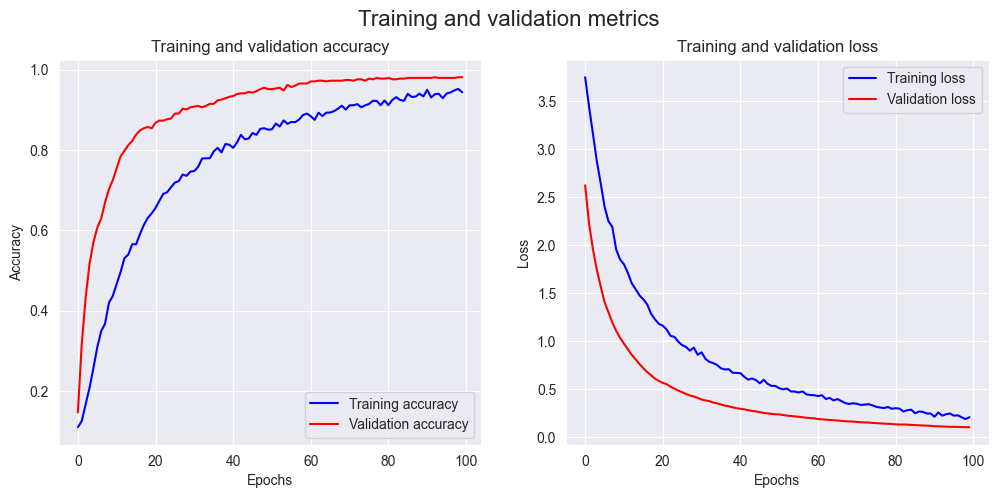

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

# Making predictions on the Test Data

In [24]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step 
The first 5 predictions: ['Panda', 'Cat', 'Cow', 'Panda', 'Deer']


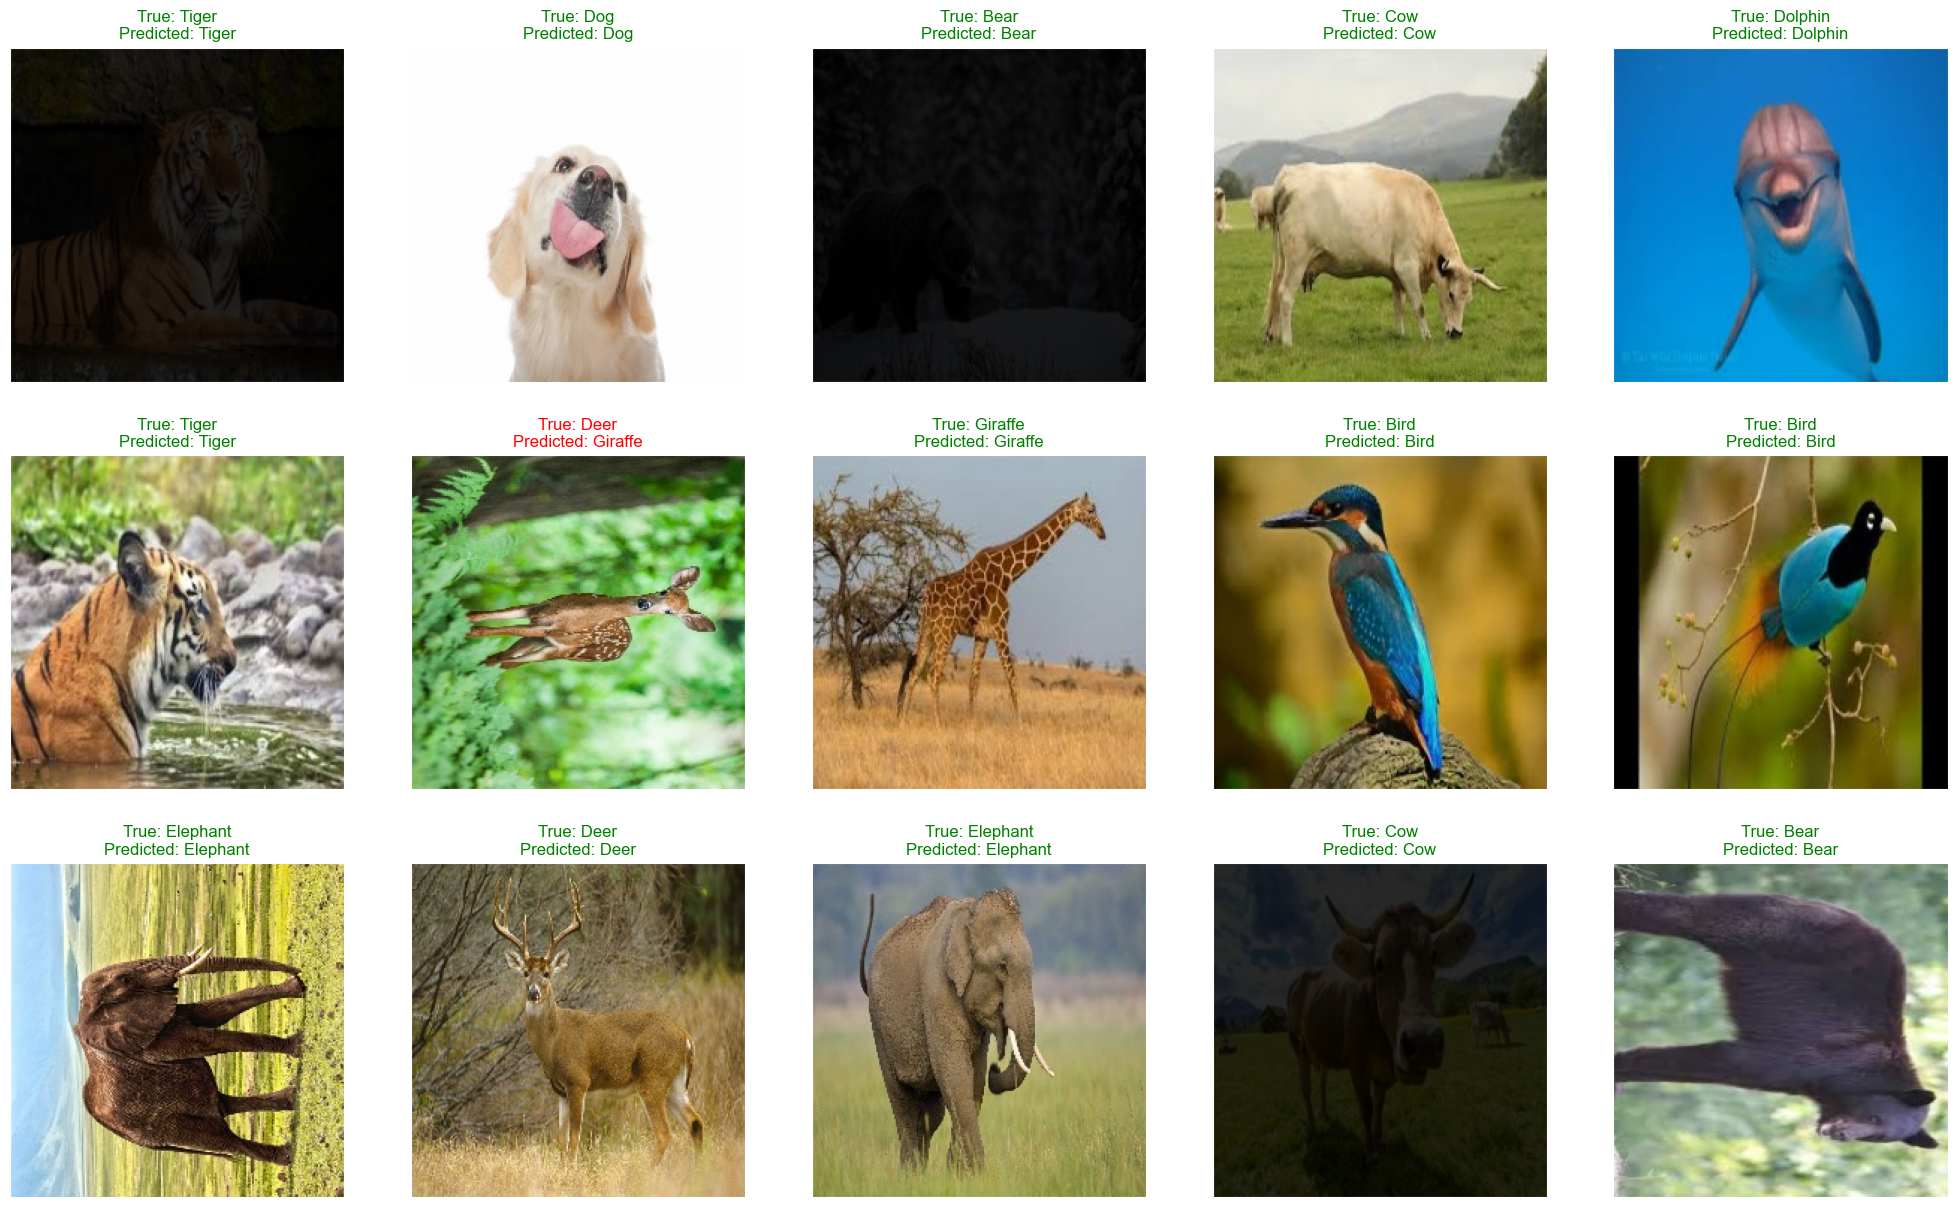

<Figure size 640x480 with 0 Axes>

In [25]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# Plotting the Classification Reports and Confusion Matrix

In [26]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        Bear       1.00      1.00      1.00        42
        Bird       0.96      0.98      0.97        52
         Cat       0.94      0.96      0.95        49
         Cow       1.00      0.98      0.99        50
        Deer       0.94      0.90      0.92        52
         Dog       1.00      0.92      0.96        49
     Dolphin       0.94      1.00      0.97        46
    Elephant       1.00      1.00      1.00        46
     Giraffe       0.89      0.96      0.92        50
       Horse       0.98      1.00      0.99        50
    Kangaroo       0.97      0.87      0.92        38
        Lion       0.98      1.00      0.99        42
       Panda       1.00      1.00      1.00        42
       Tiger       1.00      1.00      1.00        47
       Zebra       1.00      1.00      1.00        63

    accuracy                           0.97       718
   macro avg       0.97      0.97      0.97       718
weighted avg       0.97   

In [27]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Bear           1.000000  1.000000  1.000000   42.000000
Bird           0.962264  0.980769  0.971429   52.000000
Cat            0.940000  0.959184  0.949495   49.000000
Cow            1.000000  0.980000  0.989899   50.000000
Deer           0.940000  0.903846  0.921569   52.000000
Dog            1.000000  0.918367  0.957447   49.000000
Dolphin        0.938776  1.000000  0.968421   46.000000
Elephant       1.000000  1.000000  1.000000   46.000000
Giraffe        0.888889  0.960000  0.923077   50.000000
Horse          0.980392  1.000000  0.990099   50.000000
Kangaroo       0.970588  0.868421  0.916667   38.000000
Lion           0.976744  1.000000  0.988235   42.000000
Panda          1.000000  1.000000  1.000000   42.000000
Tiger          1.000000  1.000000  1.000000   47.000000
Zebra          1.000000  1.000000  1.000000   63.000000
accuracy       0.972145  0.972145  0.972145    0.972145
macro avg      0.973177  0.971372  0.971756  718.000000
weighted avg   0.972884  0.972145  0.972028  718.000000

In [28]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


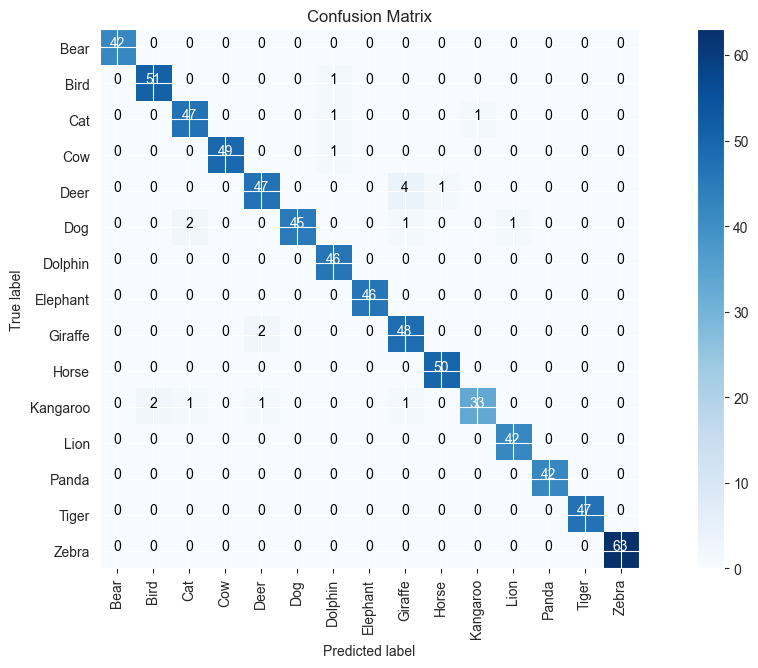

In [29]:
make_confusion_matrix(y_test, pred, list(labels.values()))

# Grad-Cam Visualization

In [30]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

C:\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1630']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
C:\Users\CHARM\AppData\Local\Temp\ipykernel_2352\3614164838.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


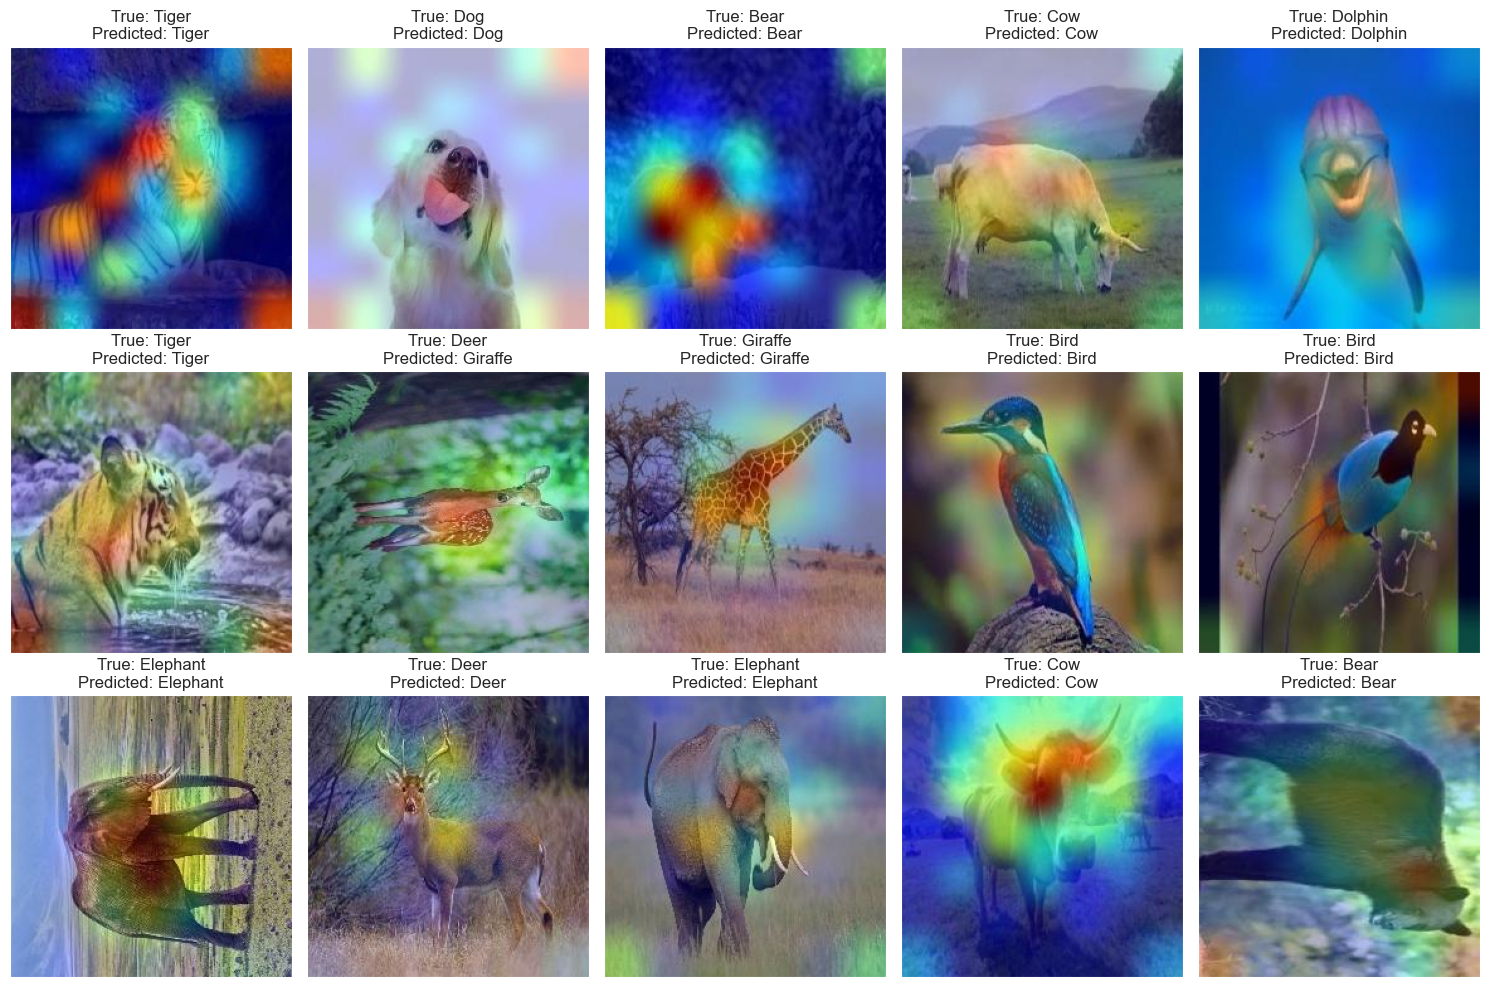

In [31]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()